# Chapter 8 
 Industrial Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (2023) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

In [1]:
import os
os.environ['OUTDATED_IGNORE'] = '1'
import warnings
from outdated import OutdatedPackageWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=OutdatedPackageWarning)

# Cybermanufacturing and Digital Twins

In [2]:
import mistat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

## Introduction to Cybermanufacturing

## Cybermanufacturing Analytics

## Information Quality in Cybermanufacturing

### Bayesian Networks

### CUB Models

### Control Charts

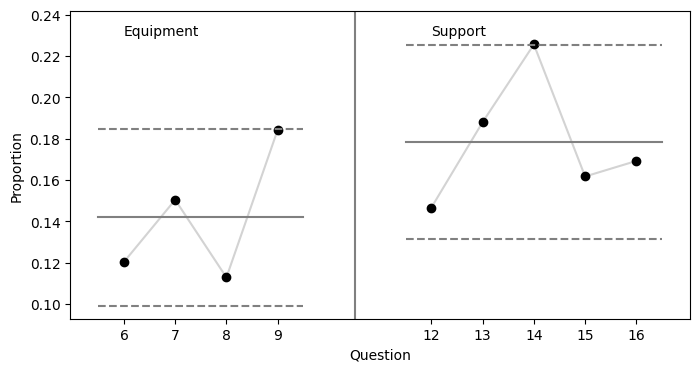

In [3]:
abc = mistat.load_data('ABC')
equipment = ['q6', 'q7', 'q8', 'q9']
support = ['q12', 'q13', 'q14', 'q15', 'q16']
top5counts = (abc[equipment + support] == 5).sum()

qcc1 = mistat.QualityControlChart(top5counts[equipment], qcc_type='np',
                                 sizes=len(abc), nsigmas=2)
qcc2 = mistat.QualityControlChart(top5counts[support], qcc_type='np',
                                 sizes=len(abc), nsigmas=2)

qcc1.data = qcc1.data / len(abc)
qcc1.center = qcc1.center / len(abc)
qcc1.limits = qcc1.limits / len(abc)
qcc2.data = qcc2.data / len(abc)
qcc2.center = qcc2.center / len(abc)
qcc2.limits = qcc2.limits / len(abc)

fig, ax = plt.subplots(figsize=(8, 4))
subsets = [
    {'x': np.array(range(6, 10)), 'qcc': qcc1},
    {'x': np.array(range(12, 17)), 'qcc': qcc2 },
]
for subset in subsets:
    qcc = subset['qcc']
    x = subset['x']
    ax.plot(x, qcc.data.values, color='lightgrey',
            marker='o', markeredgecolor='black', markerfacecolor='black')
    ax.plot((np.min(x)-0.5, np.max(x)+0.5), (qcc.center, qcc.center),
            color='grey')
    for limit in qcc.limits.values:
        ax.plot((np.min(x)-0.5, np.max(x)+0.5), (limit, limit),
            color='grey', ls='--')
ax.set_xticks(np.concatenate([subsets[0]['x'], subsets[1]['x']]))
ax.set_xlabel('Question')
ax.set_ylabel('Proportion')
ax.axvline(10.5, color='gray')
ax.text(6, 0.23, 'Equipment')
ax.text(12, 0.23, 'Support')
ylim = list(ax.get_ylim())
ylim[1] = ylim[1] + 0.01
ax.set_ylim(ylim)

plt.show()

## Modeling in Cybermanufacturing

## Computational pipelines

## Digital Twins

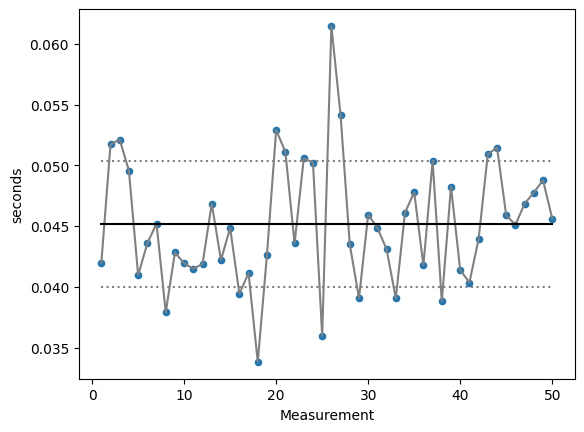

In [4]:
# Individual measurements of cycle time with all factors at center
midRange = {'m': 45, 's': 0.0125, 'k': 3_000, 't': 293, 'p0': 100_000, 'v0': 0.006, 't0': 350}
experiment = mistat.PistonSimulator(n_simulation=50, seed=1, **midRange)
Ps = experiment.simulate()
Ps['Measurement'] = np.arange(1, 51)

def addStatsLines(xlim, data, ax, color='grey'):
    stMean = np.mean(data)
    std = np.std(data)    
    ax.plot(xlim, (stMean, stMean), color='black')
    ax.plot(xlim, (stMean-std, stMean-std), color=color, linestyle=':')
    ax.plot(xlim, (stMean+std, stMean+std), color=color, linestyle=':')

ax = Ps.plot.scatter(x='Measurement', y='seconds')
ax.plot(Ps['Measurement'], Ps['seconds'], color='grey')
addStatsLines((1, 50), Ps['seconds'], ax)
plt.show()

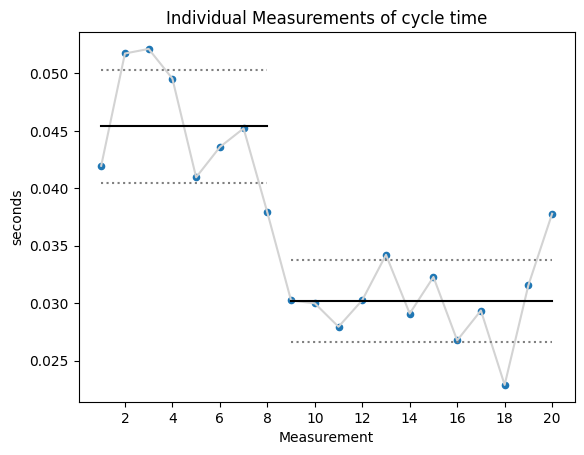

In [5]:
v0changes = dict(midRange)
v0changes['v0'] = [v0changes['v0']] * 8 + [0.0045] * 42

experiment = mistat.PistonSimulator(n_simulation=50, seed=1, **v0changes)
_ = experiment.simulate()

sensorData = experiment.actuals
sensorData['Measurement'] = np.arange(1, len(sensorData) + 1)
sensorDataShort = sensorData.iloc[:20, :]

ax = sensorDataShort.plot.scatter(x='Measurement', y='seconds', title='Individual Measurements of cycle time')
ax.plot(sensorDataShort['Measurement'], sensorDataShort['seconds'], color='lightgrey')
addStatsLines((1, 8), sensorDataShort['seconds'][:8], ax)
addStatsLines((9, 20), sensorDataShort['seconds'][8:], ax)
ax.set_xticks(np.arange(2, 20+1, 2))
plt.show()

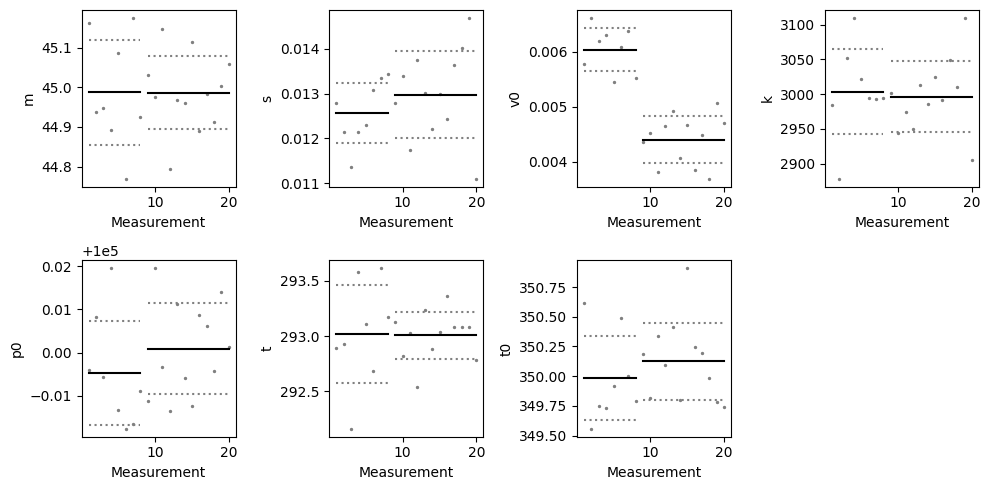

In [6]:
factors = ['m', 's', 'v0', 'k', 'p0', 't', 't0']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
ymin, ymax = None, None
for ax, factor in itertools.zip_longest(itertools.chain.from_iterable(axes), factors):
    if factor is None:
        ax.set_axis_off()
        continue
        
    ax.scatter(sensorDataShort['Measurement'], sensorDataShort[factor], s=2, color='grey')
    addStatsLines((1, 8), sensorDataShort[factor][:8], ax)
    addStatsLines((9, 20), sensorDataShort[factor][8:], ax)
    ax.set_xlabel('Measurement')
    ax.set_ylabel(factor)

plt.tight_layout()
plt.show()

In [7]:
from mistat.design import doe

Factors = {
    'm': (30, 60),
    's': (0.005, 0.02),
    'k': (1_000, 5_000),
    't': (290, 296),
    'p0': (90_000, 110_000),
    'v0': (0.002, 0.01),
    't0': (340, 360),
}
Design = doe.lhs(Factors, num_samples=1280)
Design = Design.to_dict(orient = 'list')
experiment = mistat.PistonSimulator(n_simulation=1, seed=1, **Design)
experimentData = experiment.simulate()

{'regressor__mlpregressor__hidden_layer_sizes': (5,)}


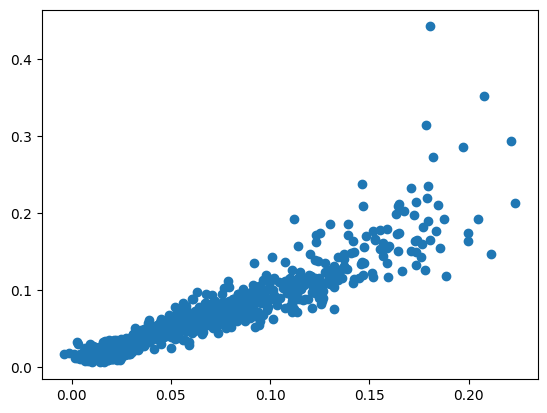

In [8]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor

predictors = ['m', 's', 'k', 't', 'p0', 'v0', 't0']
X = experimentData[predictors]
y = experimentData['seconds']

param_grid = {'regressor__mlpregressor__hidden_layer_sizes': [tuple([i+1]) for i in range(2, 10)]}

base_estimator = TransformedTargetRegressor(
    regressor=make_pipeline(
        MinMaxScaler(),
        MLPRegressor(
            max_iter=1000, 
            activation='tanh',
            hidden_layer_sizes=(1, ),
            learning_rate_init=0.01,
            early_stopping=True,
            random_state=0,
        )
    ),
    transformer=MinMaxScaler(),
)

model = GridSearchCV(base_estimator, param_grid, cv=5)
model.fit(X, y)

print(model.best_params_)
model.best_estimator_

fig, ax = plt.subplots()
ax.scatter(model.predict(X), y)
plt.show()

In [9]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor

predictors = ['m', 's', 'k', 't', 'p0', 'v0', 't0']
X = experimentData[predictors]
y = experimentData['seconds']

# create a pipeline that first scales the predictors to the range 0 to 1
# followed by a neural network model. The outcome variable is also 
# rescaled to a range of 0 to 1. This is achieved using TransformedTargetRegressor.
model = TransformedTargetRegressor(
    regressor=make_pipeline(
        MinMaxScaler(),
        MLPRegressor(max_iter=1000, activation='tanh',
            hidden_layer_sizes=(5, ), learning_rate_init=0.01, 
            early_stopping=True, random_state=0,
        )
    ),
    transformer=MinMaxScaler(),
)
_ = model.fit(X, y)

In [10]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X, y, n_repeats=10, random_state=0)
result.importances_mean
result.importances_std
permImportance = pd.DataFrame({
    'predictor': predictors,
    'mean': result.importances_mean,
    'std': result.importances_std,
    'low': result.importances_mean - result.importances_std,
    'high': result.importances_mean + result.importances_std,
})
permImportance

,predictor,mean,std,low,high
0,m,0.005861,0.001219,0.004642,0.007080
1,s,1.003673,0.035254,0.968419,1.038927
2,k,0.021804,0.002979,0.018825,0.024783
3,t,0.000019,0.000628,-0.000610,0.000647
4,p0,0.010507,0.004183,0.006324,0.014690
5,v0,0.875387,0.019530,0.855858,0.894917
6,t0,0.000880,0.000537,0.000343,0.001417


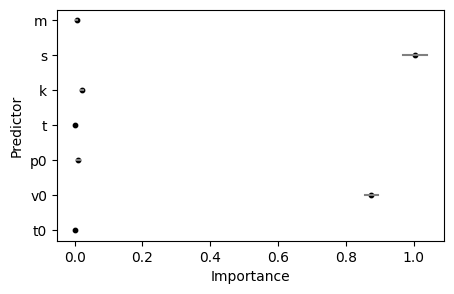

In [11]:
fig, ax = plt.subplots(figsize=(5, 3))
for _, row in reversed(list(permImportance.iterrows())):
    p = row['predictor']
    ax.plot((row['low'], row['high']), (p, p), color='grey')
ax.scatter(permImportance['mean'], permImportance['predictor'], color='black', s=10)
ax.set_xlabel('Importance')
ax.set_ylabel('Predictor')
plt.show()

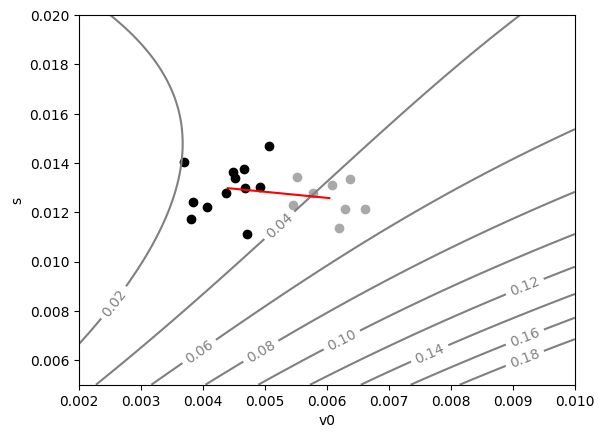

In [12]:
sensorDataMean = dict(sensorData.mean())

def plotResponseSurface(model, levels):
    steps = 100
    x1 = np.linspace(*(Factors['v0']), steps)
    x2 = np.linspace(*(Factors['s']), steps)
    X1, X2 = np.meshgrid(x1, x2)
    gridData = dict(sensorDataShort.mean())
    gridData = pd.DataFrame({
        **sensorDataMean, # use mean values of all other factors from the sensorData
        's': X2.ravel(),
        'v0': X1.ravel(),
    })
    gridData = gridData[list(Factors)]
    responses = model.predict(gridData)
    CS = plt.contour(x1, x2, responses.reshape(steps, steps),
                sorted(list(levels)), colors='gray')
    ax = plt.gca()
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_xlabel('v0')
    ax.set_ylabel('s')
    return ax
ax = plotResponseSurface(model, np.arange(0.0, 0.2, 0.02))
ax.plot([np.mean(sensorDataShort['v0'][:8]), np.mean(sensorDataShort['v0'][8:])], 
        [np.mean(sensorDataShort['s'][:8]), np.mean(sensorDataShort['s'][8:])], color='red')
ax.scatter(sensorDataShort['v0'][:8], sensorDataShort['s'][:8], color='darkgrey')
ax.scatter(sensorDataShort['v0'][8:], sensorDataShort['s'][8:], color='black')
plt.show()

In [13]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from statsmodels.tsa.api import SARIMAX

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

results = None
# generate all combinations of (p, d, q) triplets and keep the model 
# with the lowest AIC
for param in list(itertools.product(p, d, q)):
    mod = SARIMAX(sensorDataShort['v0'], order=param)
    temp = mod.fit(method='nm', maxiter=600, disp=False)
    if results is None or results.aic > temp.aic:
        results = temp
print('ARIMA{} - AIC:{}'.format(param, results.aic))

ARIMA(2, 2, 2) - AIC:-226.33201069362354


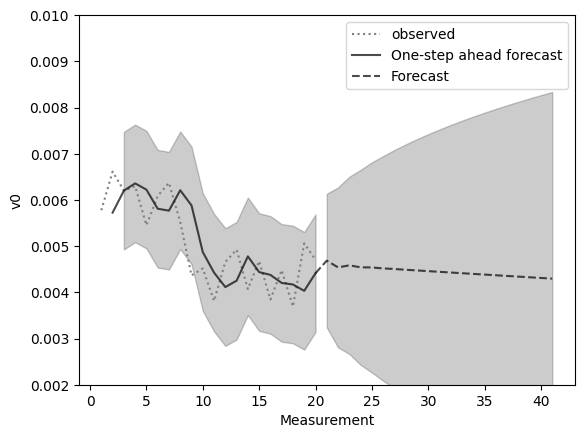

In [14]:
def addSARIMAX_predictions(predictions, ax, label=None, linestyle=None):
    pred_mean = predictions.predicted_mean
    pred_mean.index = pred_mean.index + 1
    pred_mean.plot(ax=ax, label=label, alpha=.7, color='black', linestyle=linestyle)
    pred_ci = predictions.conf_int()
    pred_ci.index = pred_ci.index + 1
    ax.fill_between(pred_ci.index[1:],
                    pred_ci['lower v0'].iloc[1:], pred_ci['upper v0'].iloc[1:], 
                    color='k', alpha=0.2)

ax = sensorDataShort[['Measurement', 'v0']].plot(x='Measurement', y='v0', label='observed', 
                                                 color='grey', linestyle=':')
predictions = results.get_prediction(start=1)
addSARIMAX_predictions(predictions, ax, label='One-step ahead forecast')
forecast = results.get_prediction(start=19, end=40, dynamic=True, full_results=True)
addSARIMAX_predictions(forecast, ax, label='Forecast', linestyle='--')

ax.set_xlabel('Measurement')
ax.set_ylabel('v0')
ax.set_ylim(0.002, 0.01)
plt.legend()

plt.show()

## Chapter Highlights

## Exercises